Clustering and classification for features extracted from tiles modified with StainNet.

---
# 0. - Imports and paths

In [15]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

In [16]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [17]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

In [18]:
model = "UNI2-h"

In [19]:
# PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/"
# COMPARISON = "satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots"

# SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle'
# SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET.pickle'

In [20]:
PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots/"
COMPARISON = "satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots"

SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle'
SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_stainNET.pickle'

In [21]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining the path to the figures.

In [22]:
PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}"
os.makedirs(PATH_TO_FIGURES, exist_ok=True)

# 1. - Importing the extracted features

First of all, let's see all the MERGED `.pickle` files inside the folder of the saved features.

In [23]:
all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith('.pickle')]

print(f"{len(all_pickle_names)} .pickle files inside the folder.\n")
print(all_pickle_names)

8 .pickle files inside the folder.

['MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_alls

And let's choose the first file to visualise and extract the normalisation name from it.

In [24]:
TILE_SIZE = 100
SPOT_SIZE = 68

# Extractin the normalisation name from just one of it. They are the same in the end
# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE_100um)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE_100um.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

stainNET


In [25]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_100um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_100um))
merged_selected_pickle_df_100um

0         1     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.033423  0.589066   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.438272  0.273205   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.132595  0.195348   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.143234 -0.231655   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta... -0.245308  0.649397   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET.jpg  -0.330629 -0.544133   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET.jpg   0.193643 -0.654369   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET.jpg   0.303627 -0.045448   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET.jpg   0.011498 -0.421936   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET.jpg   0.271338  0.143793   

                                                        2         3     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.134332 -0.069020   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.391030 -0.057215   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.252739 -0.066557   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.384484 -0.004440   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.018120 -0.097308   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET.jpg   0.078692  0.143993   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET.jpg   0.141311  0.000917   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET.jpg  -0.116704  0.031021   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET.jpg   0.305015 -0.117768   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET.jpg   0.048856  0.021380   

                                                        4         5     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.076696 -0.770055   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.302720 -0.709600   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.105471 -0.523216   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.030816 -0.353873   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.057878 -0.654822   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET.jpg  -0.067425 -0.521927   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET.jpg  -0.163774 -0.008973   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET.jpg   0.209364 -0.491832   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET.jpg  -0.326145 -0.835958   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET.jpg  -0.136201 -0.380401   

                                                        6         7     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.012218 -0.395377   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.267263 -0.959007   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.112800 -1.029253   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.085034 -0.404443   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.295820 -0.761968   
...                                                      ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_100um_stainNET.jpg   0.020633 -0.013075   
CGGGCGATGGATCACG-1_row69_col75_100um_stainNET.jpg  -0.088393 -0.514457   
TGCGGACTTGACTCCG-1_row68_col76_100um_stainNET.jpg  -0.278926 -0.268984   
TCGCTGCCAATGCTGT-1_row68_col80_100um_stainNET.jpg   0.028418 -0.040429   
GGTGTAGGTAAGTAAA-1_row70_col50_100um_stainNET.jpg  -0.037114 -0.002947   

                                                        8         9     ...  \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.280108  0.370694  ...   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.226993  0.198135  ...   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.300439  0.113934  ...   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.172420  0.356898  ...   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.448445  0.115693  ...   
...                       

In [26]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_68um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_68um))
merged_selected_pickle_df_68um

0         1     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg     -0.040355  0.011176   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg     -0.103129  0.462296   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg     -0.181745  0.402894   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg      0.045683  0.068425   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg      0.061904 -0.028368   
...                                                    ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET.jpg -0.159512 -0.221446   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET.jpg  0.150415 -0.692053   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET.jpg  0.321544  0.109994   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET.jpg -0.176859 -0.332783   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET.jpg  0.282561  0.144878   

                                                      2         3     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg     -0.171505 -0.117437   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg     -0.107971 -0.142071   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg     -0.093540 -0.089285   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg      0.096123 -0.220025   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg     -0.073345 -0.092944   
...                                                    ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET.jpg -0.251624 -0.105198   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET.jpg  0.342158 -0.019074   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET.jpg -0.155510 -0.115668   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET.jpg  0.235818 -0.049782   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET.jpg  0.070131 -0.021605   

                                                      4         5     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg      0.134034 -0.336765   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg     -0.002877 -0.670711   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg      0.069179 -0.526511   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg      0.046298 -0.192836   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg     -0.105242 -0.491636   
...                                                    ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET.jpg -0.067194 -0.143690   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET.jpg -0.190731  0.347282   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET.jpg -0.029011 -0.471803   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET.jpg -0.350004 -0.592120   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET.jpg  0.001041 -0.724232   

                                                      6         7     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg     -0.045594 -0.856168   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg     -0.067777 -0.563453   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg     -0.194443 -0.559690   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg     -0.085324 -0.785023   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg     -0.298038 -0.593388   
...                                                    ...       ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET.jpg  0.172842 -0.175036   
CGGGCGATGGATCACG-1_row69_col75_68um_stainNET.jpg -0.082178 -0.751145   
TGCGGACTTGACTCCG-1_row68_col76_68um_stainNET.jpg -0.192131 -0.269567   
TCGCTGCCAATGCTGT-1_row68_col80_68um_stainNET.jpg  0.171278 -0.296466   
GGTGTAGGTAAGTAAA-1_row70_col50_68um_stainNET.jpg -0.144723 -0.342908   

                                                      8         9     ...  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg      0.329597  0.410358  ...   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg      0.014459  0.189354  ...   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg      0.300501  0.386626  ...   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg      0.170747  0.389506  ...   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg      0.158413  0.493568  ...   
...                                                    ...       ...  ...   
GCCCTGAGGATGGGCT-1_row68_col74_68um_stainNET.jpg -0.006

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

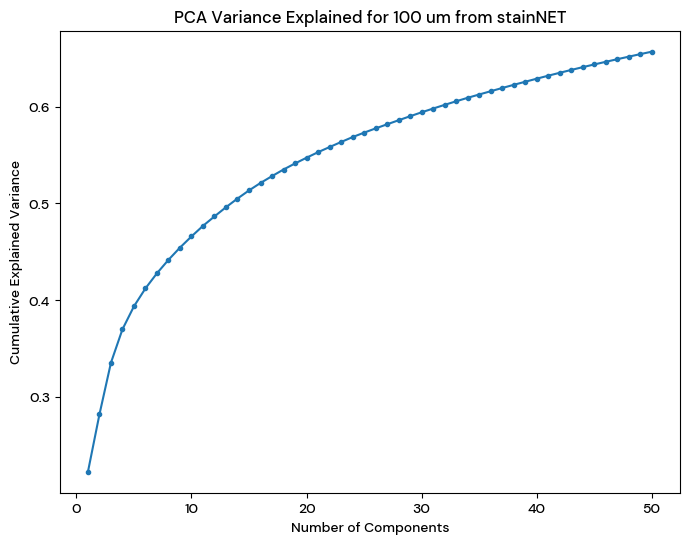

In [27]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


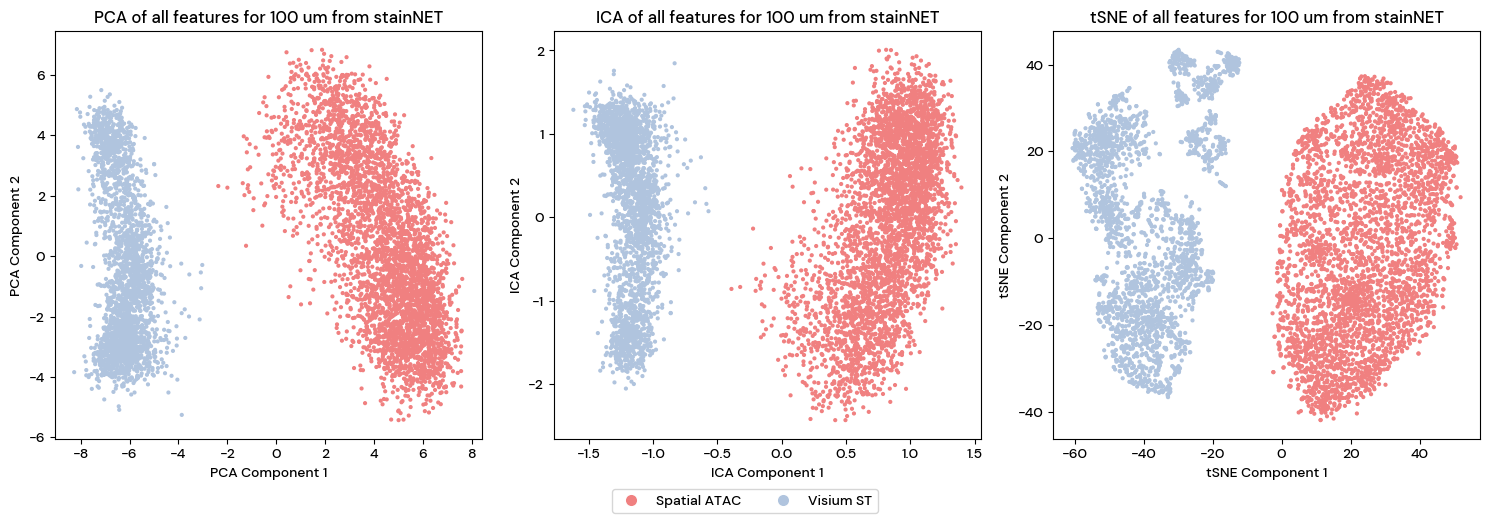

In [28]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_100.show()

In [29]:
plot_100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

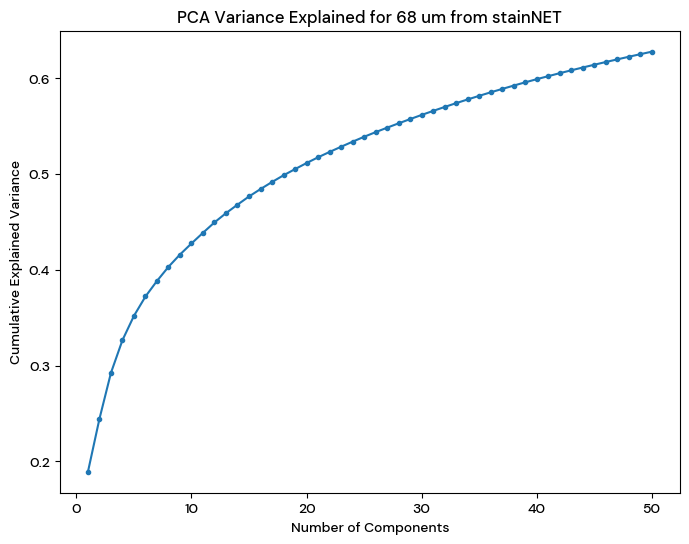

In [30]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


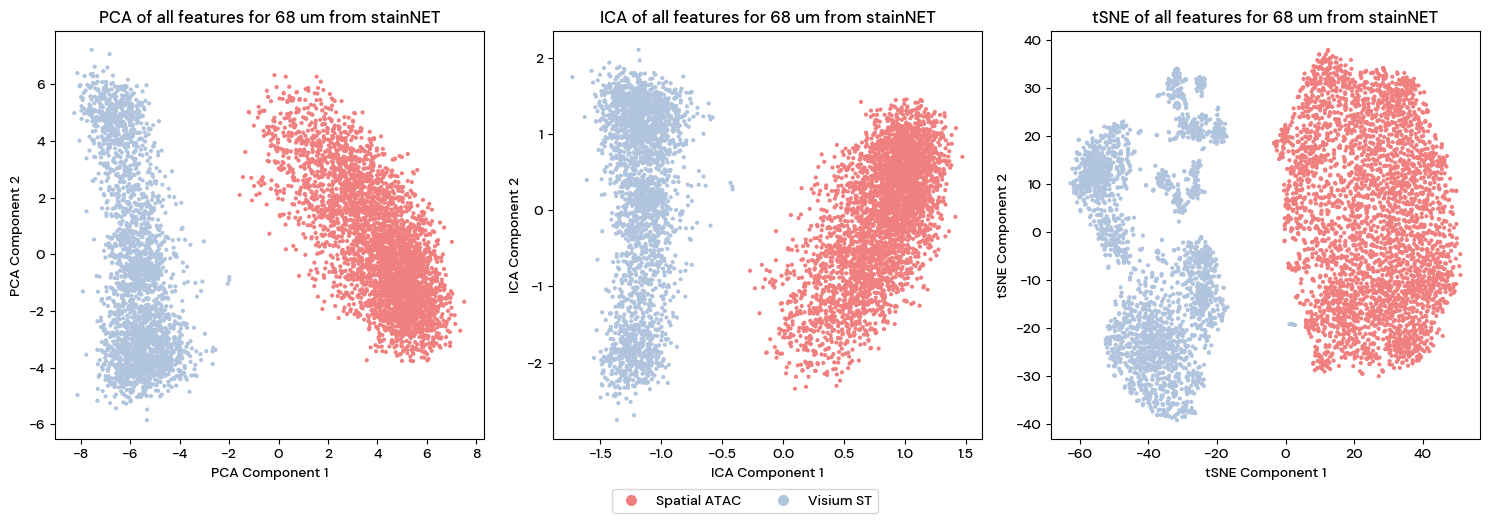

In [31]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_68.show()

In [32]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

# 3. - Clustering

In [18]:
dim_red_results_100["PCA"]

array([[ 7.4599752 ,  2.8215885 ],
       [ 8.287314  , -0.01099305],
       [ 7.5920606 ,  0.40833068],
       ...,
       [-3.8559983 , -1.0735452 ],
       [-4.004223  , -4.761414  ],
       [-4.3771253 , -1.7236993 ]], dtype=float32)

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_218460/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


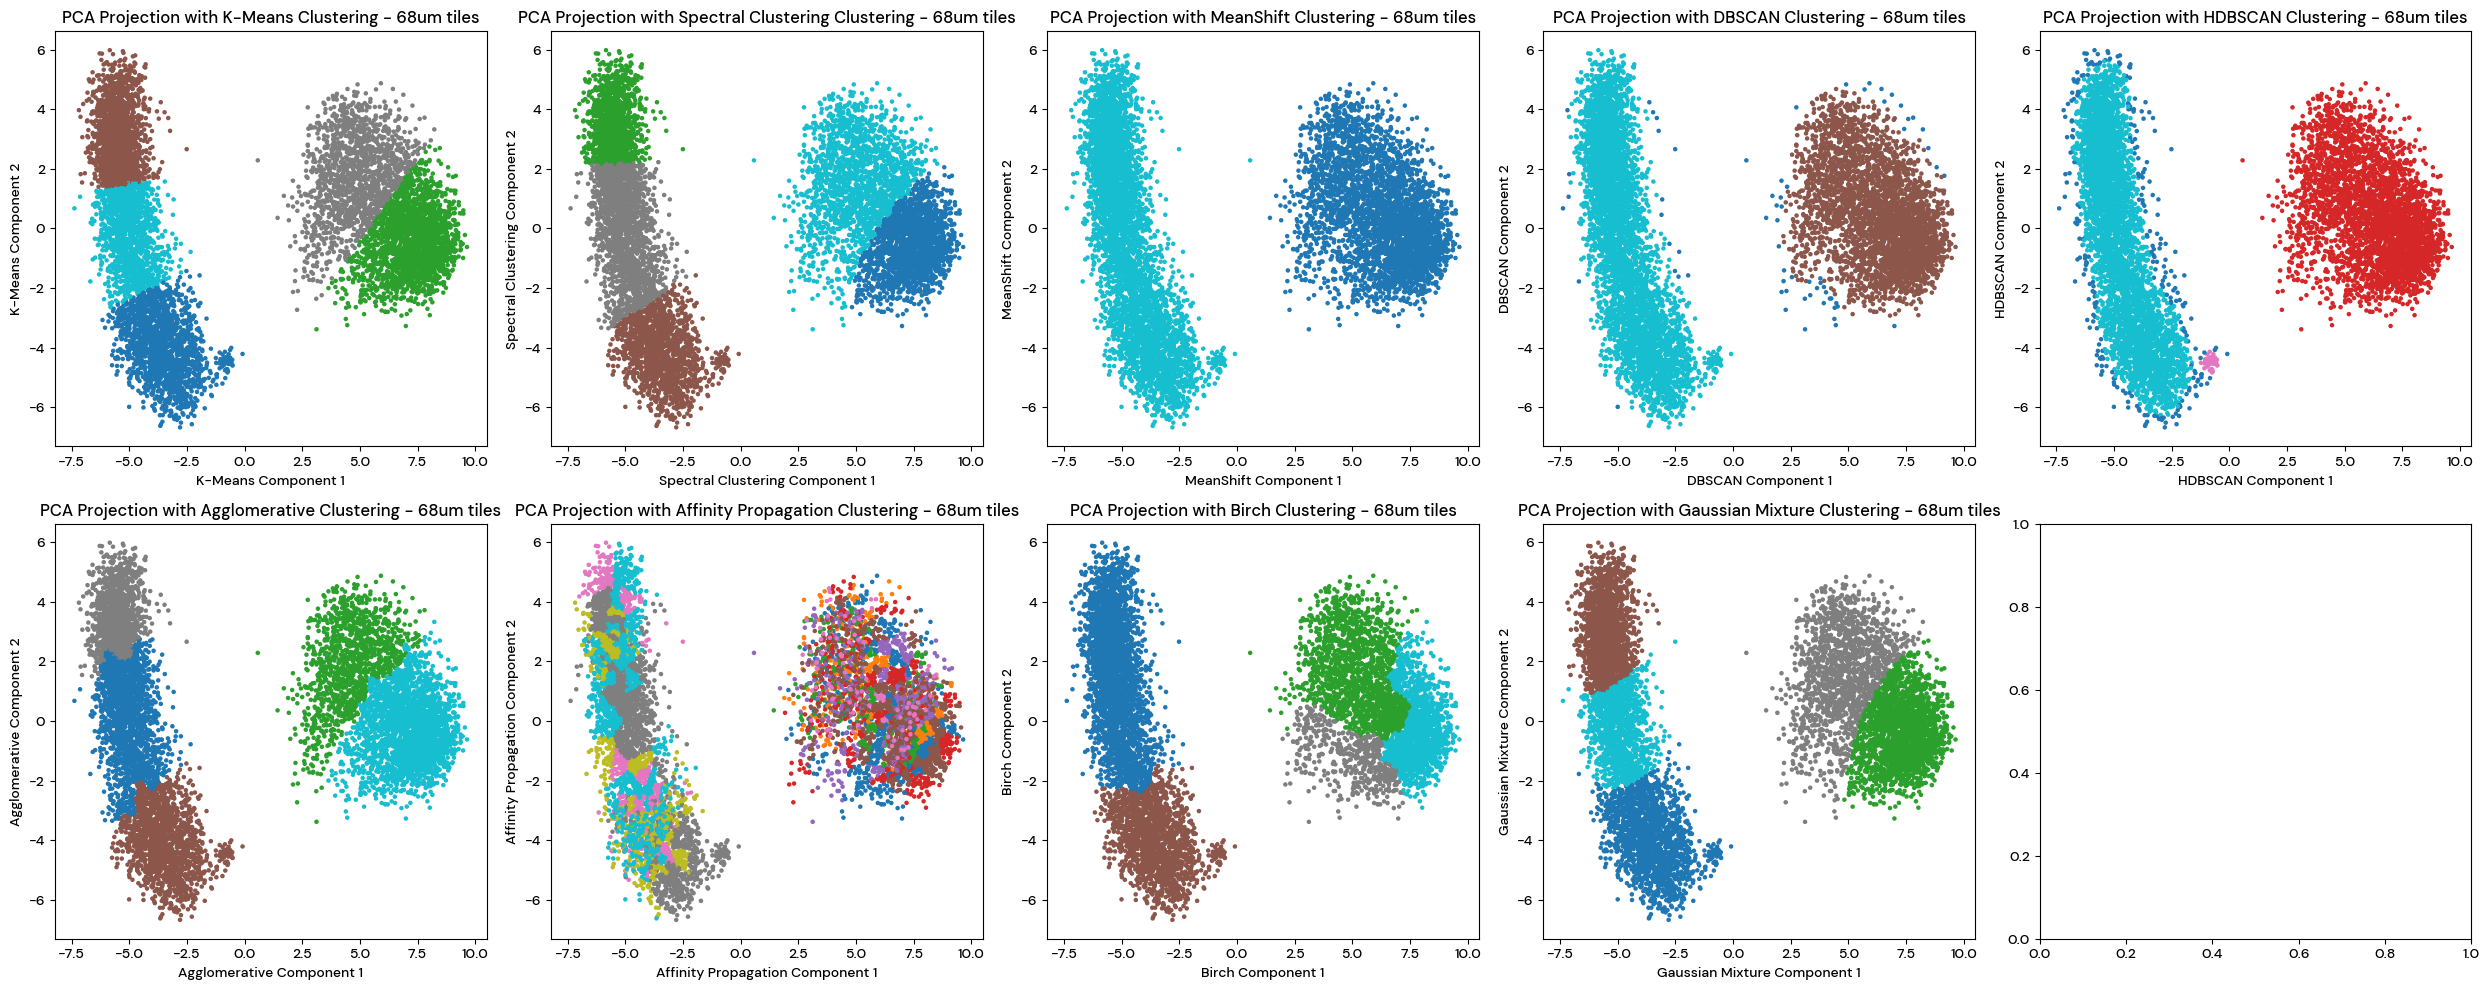

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_218460/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


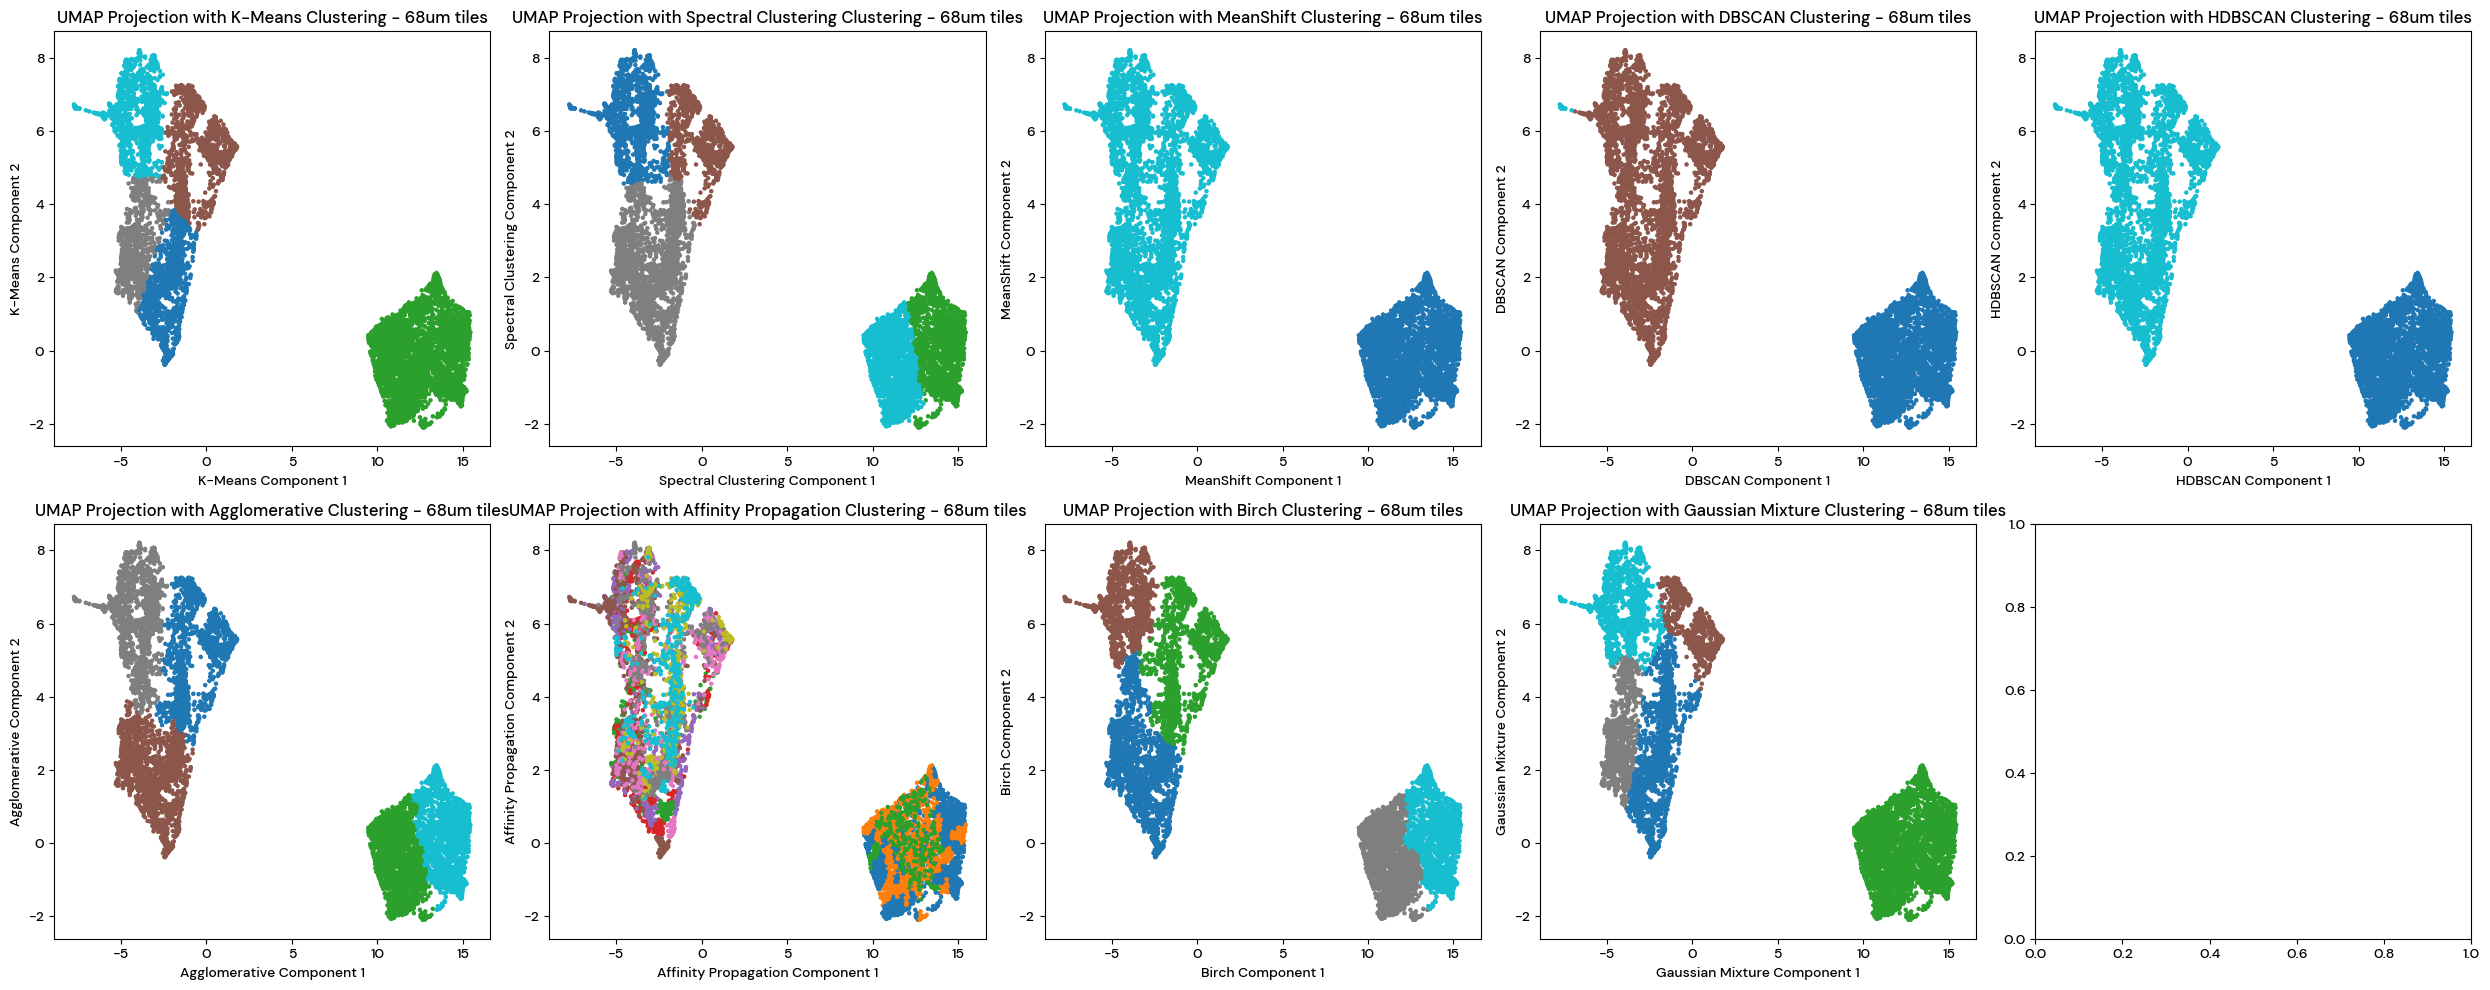

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_218460/1340331449.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


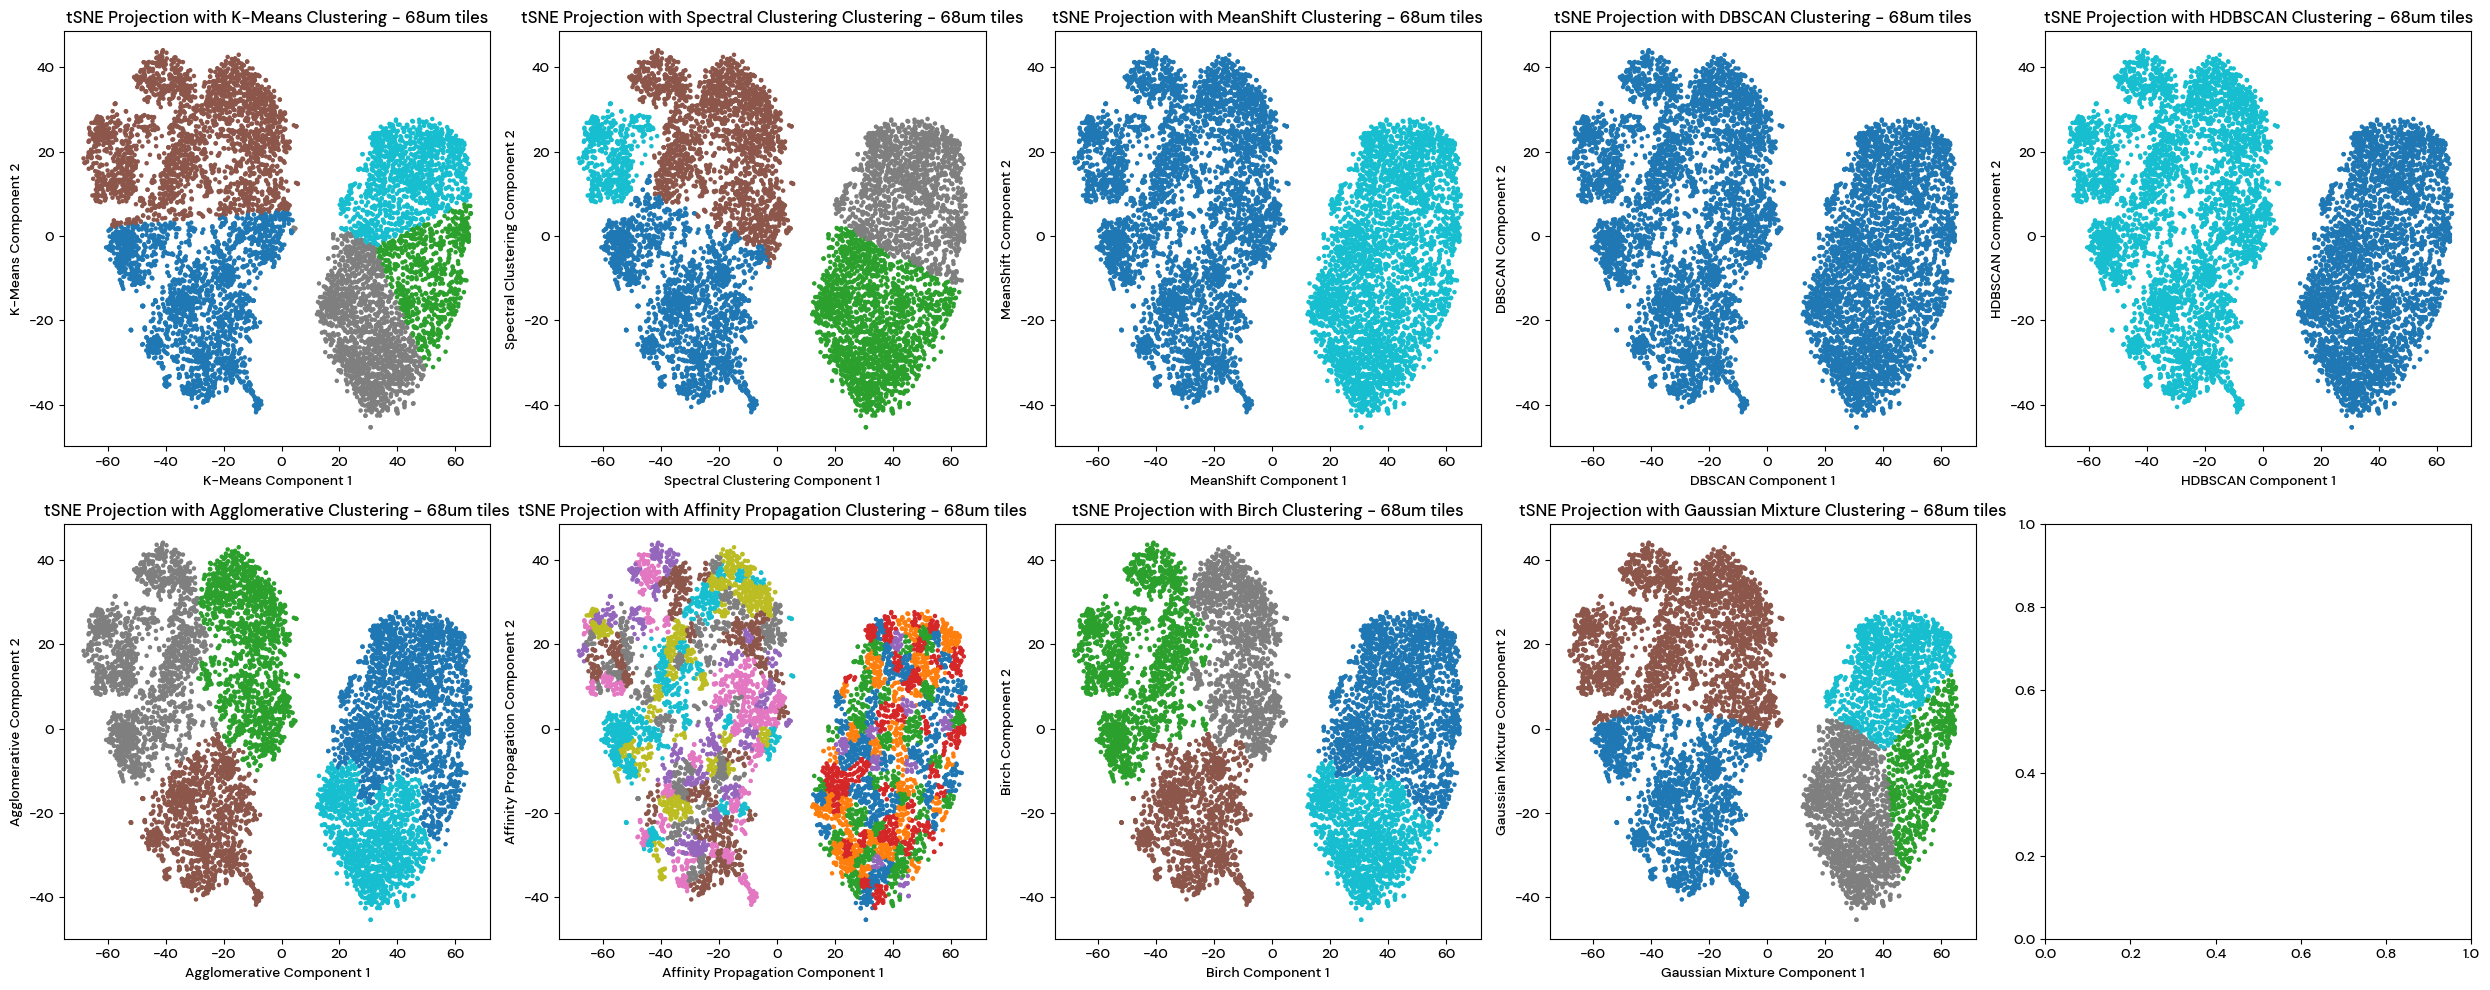

In [19]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results_100.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results_100[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results_100[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results_100[tech][:, 0], dim_red_results_100[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_218460/3630633589.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


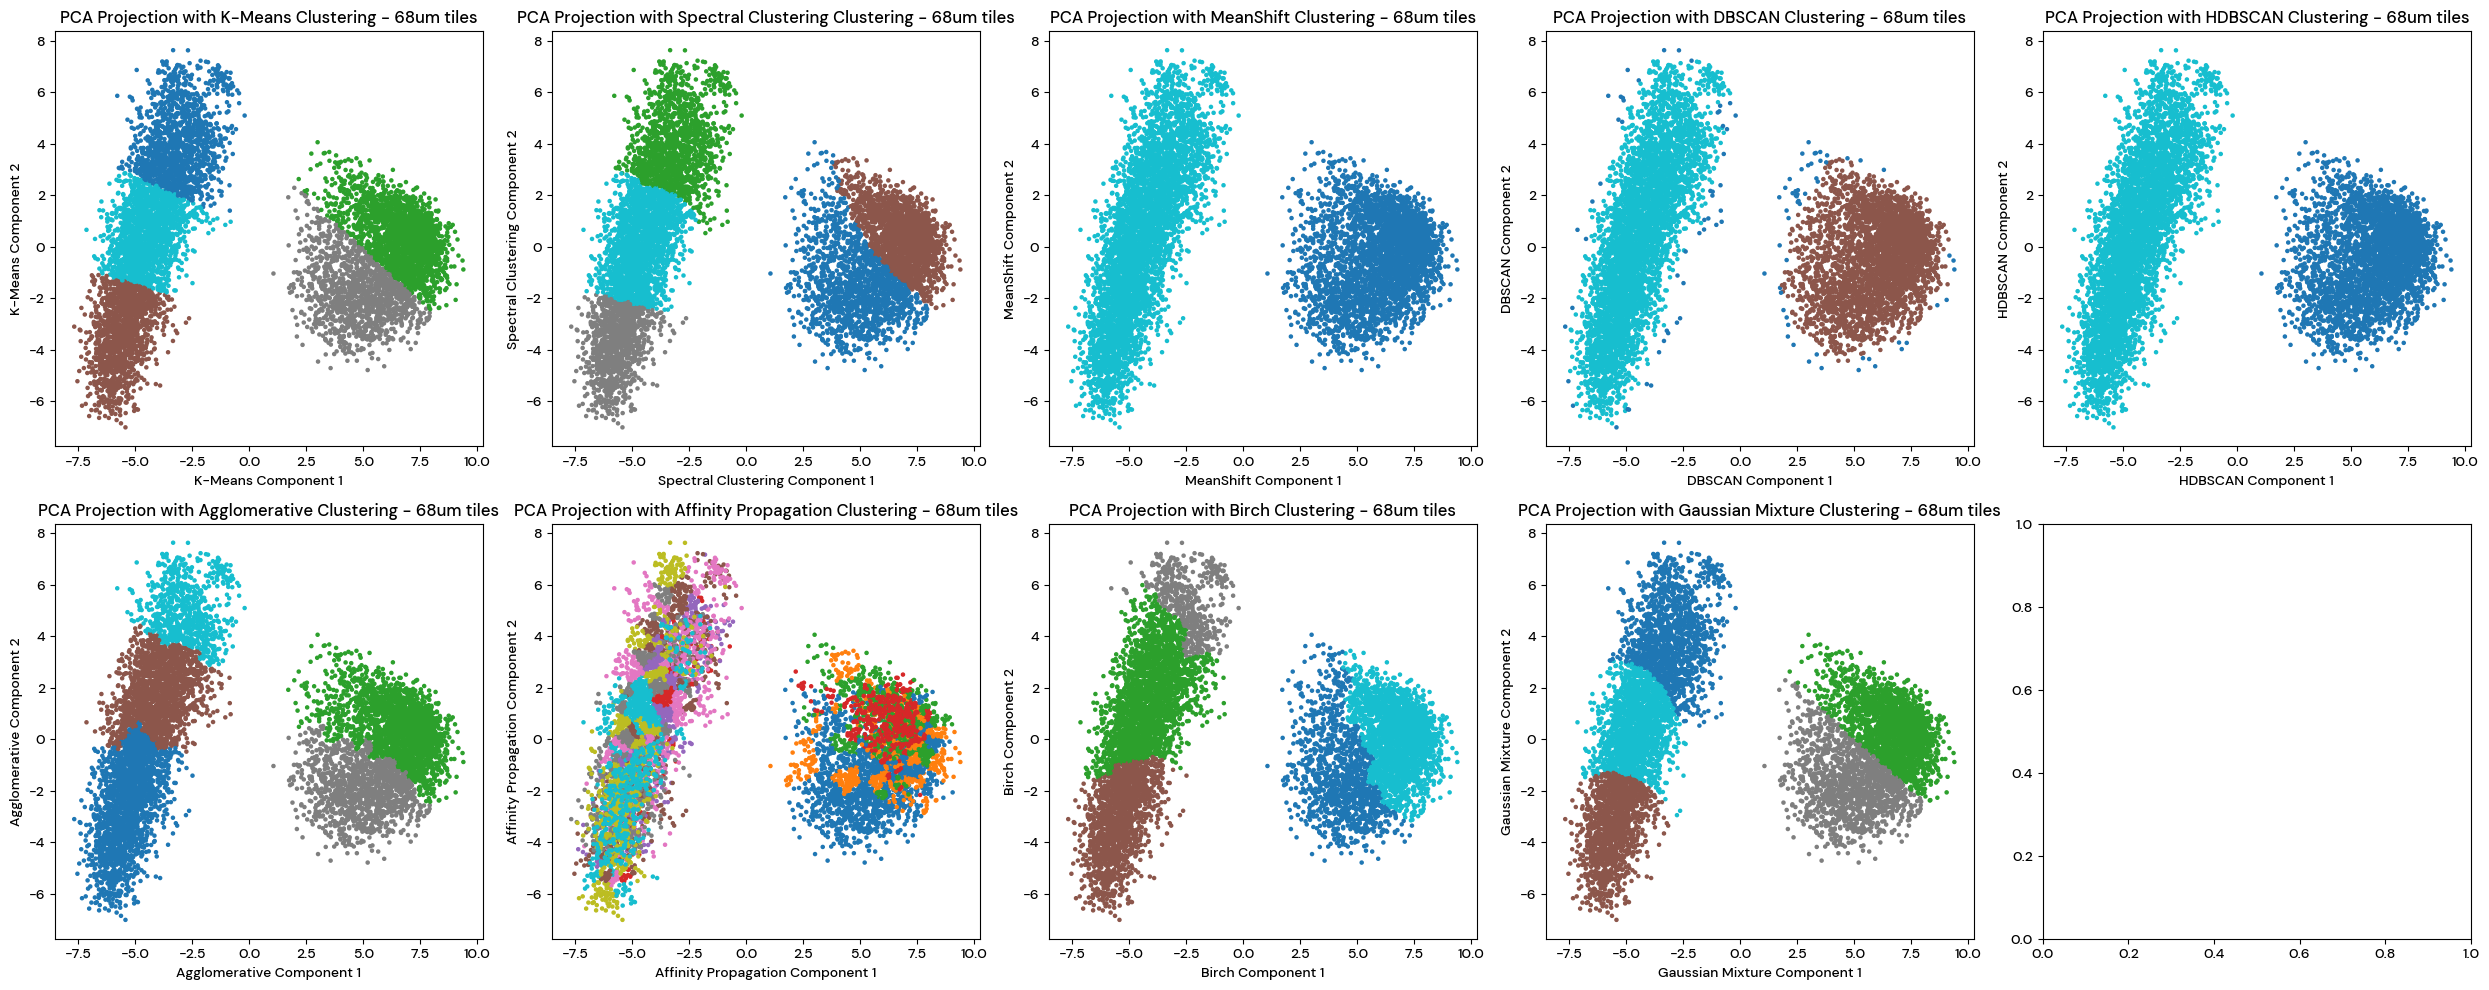

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_218460/3630633589.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


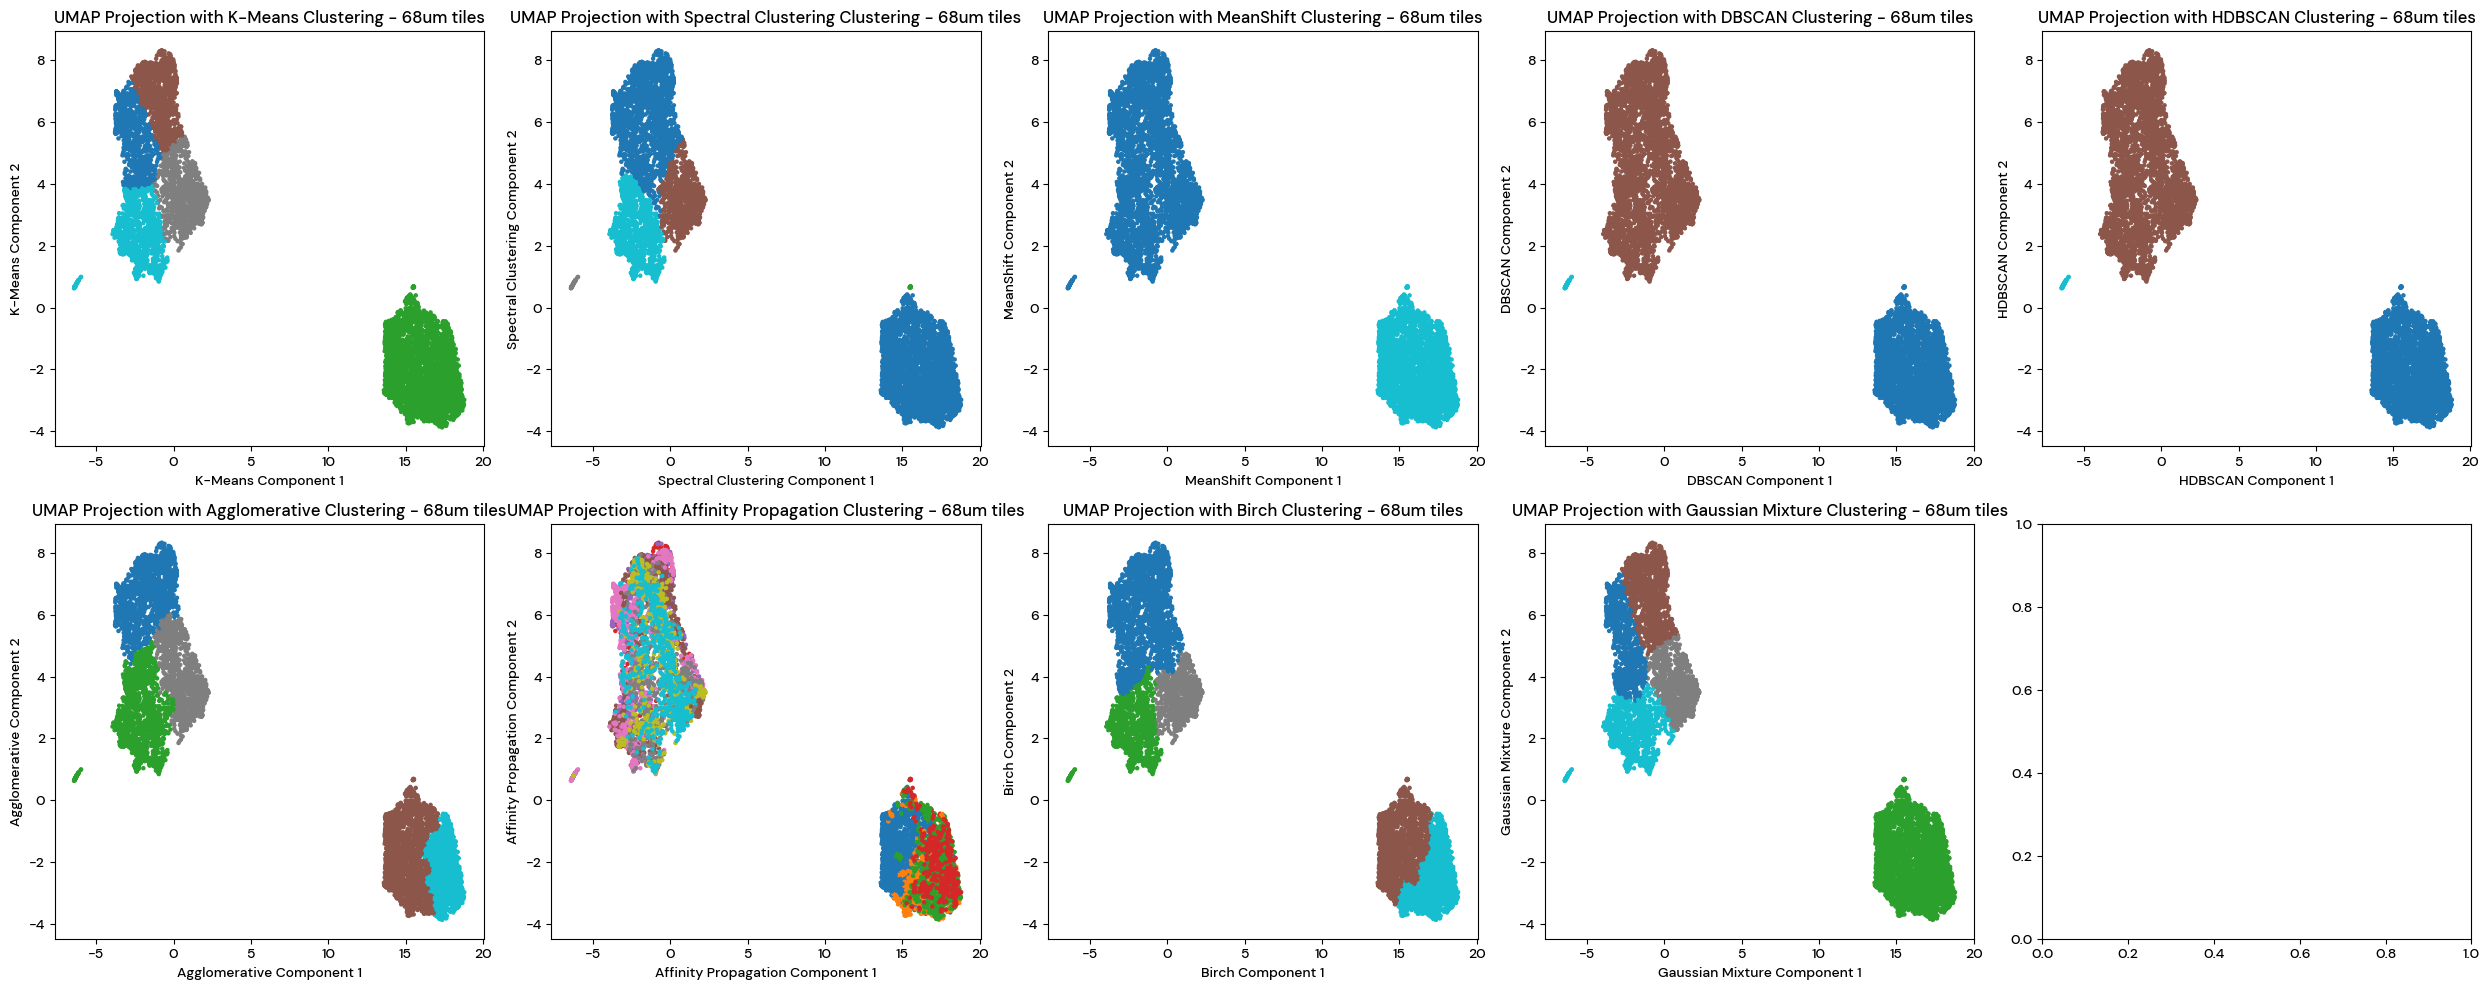

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_218460/3630633589.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


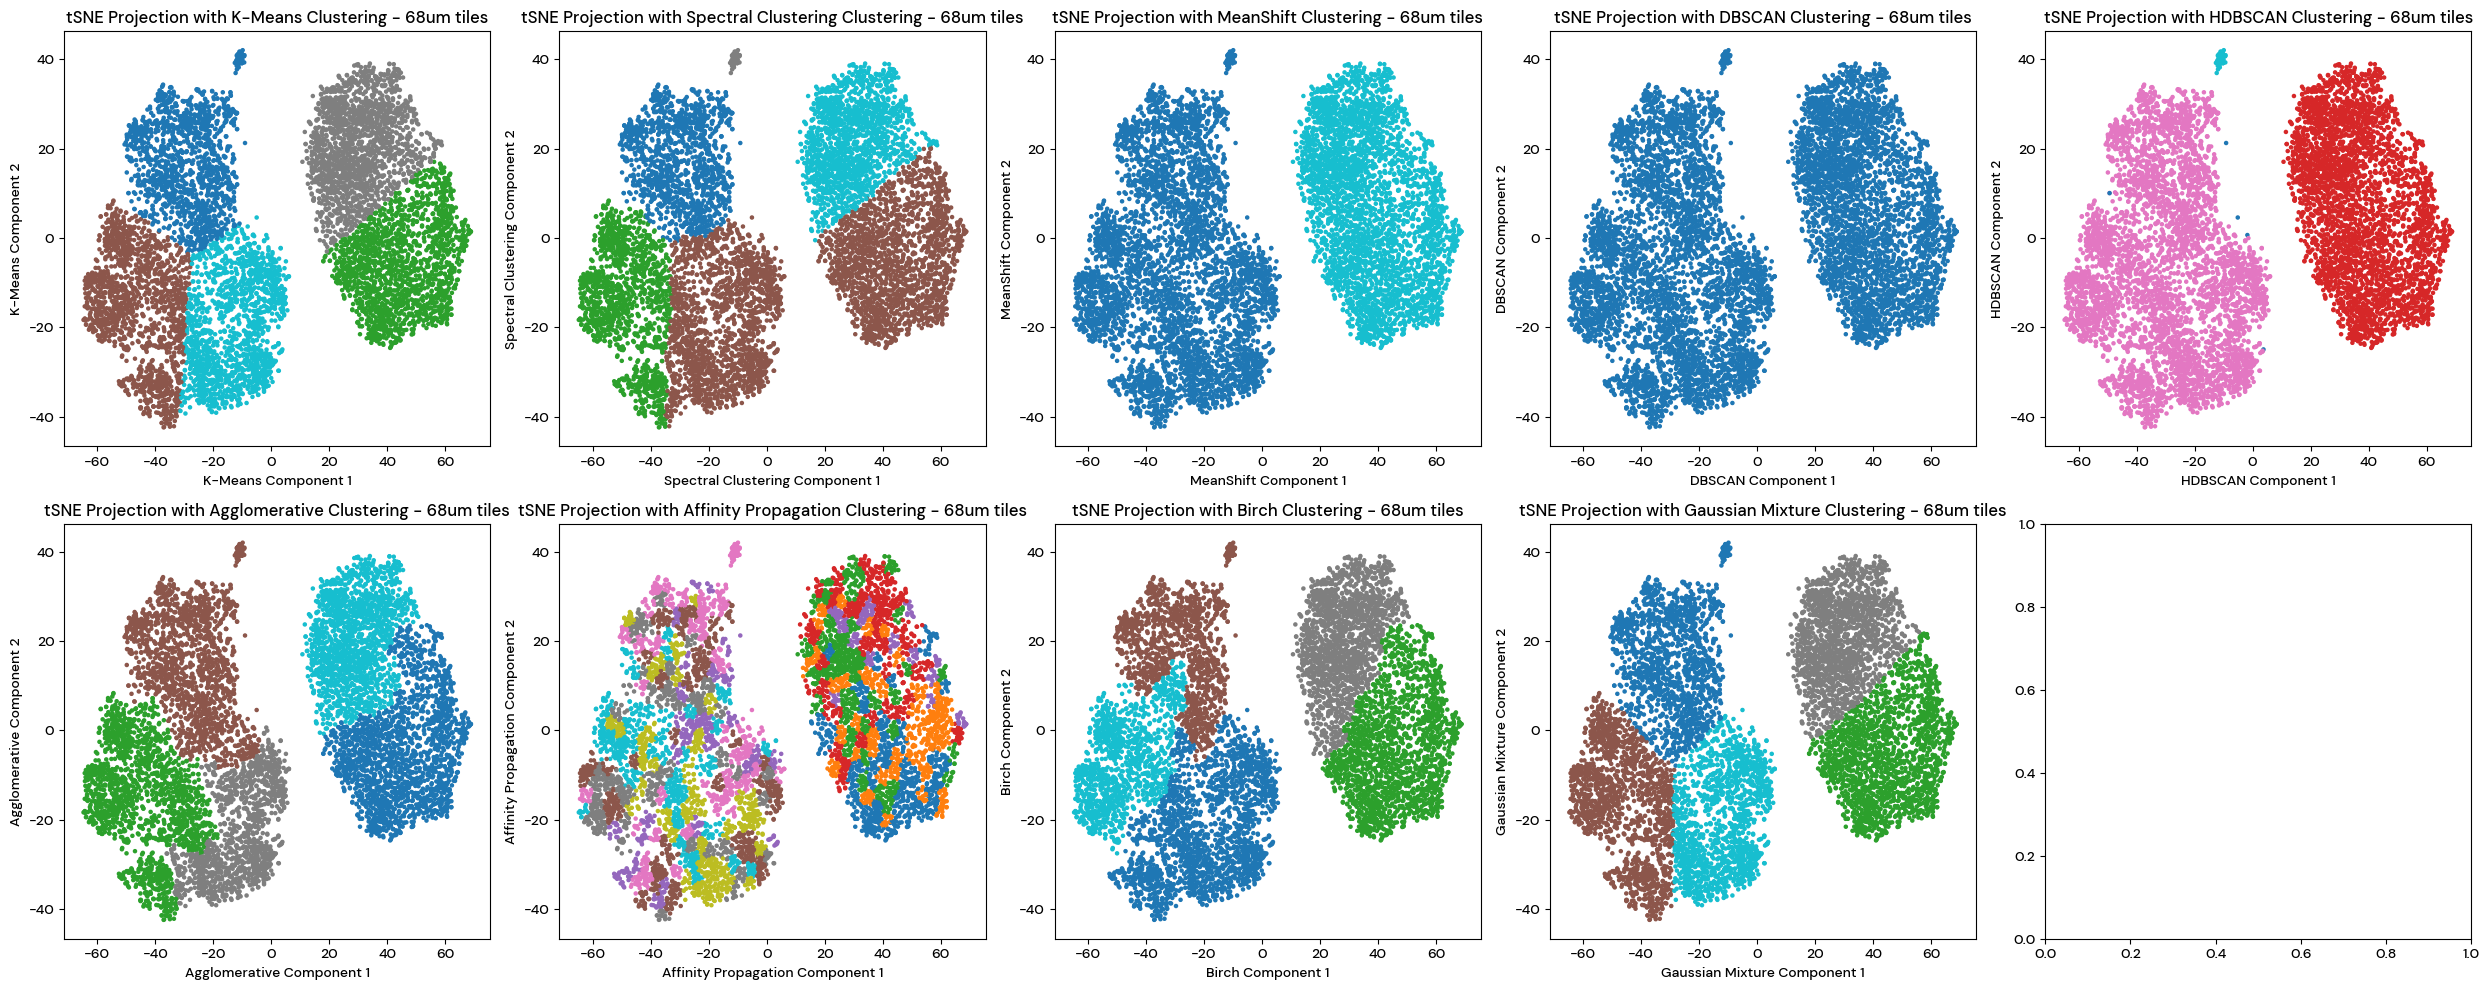

In [20]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results_68.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results_68[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results_68[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results_68[tech][:, 0], dim_red_results_68[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()

In [21]:
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture

def plot_clustering_methods(first_2_comp, selected_methods):
    clustering_methods = {
        "K-Means": KMeans(n_clusters=5, random_state=123),
        "Spectral Clustering": SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                                   eigen_solver='arpack', random_state=123),
        "MeanShift": MeanShift(),  # bandwidth will be estimated later
        "DBSCAN": DBSCAN(eps=0.5, min_samples=20),
        "HDBSCAN": HDBSCAN(min_cluster_size=20),
        "Agglomerative": AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward'),
        "Affinity Propagation": AffinityPropagation(preference=-50),  # Adjust preference as needed
        "Birch": Birch(threshold=0.5, n_clusters=5),  # Adjust threshold as needed
        "Gaussian Mixture": GaussianMixture(n_components=5, random_state=123)
    }
    
    selected_clustering_methods = [(name, clustering_methods[name]) for name in selected_methods if name in clustering_methods]
    
    n_methods = len(selected_clustering_methods)
    rows = 2
    cols = math.ceil(n_methods / rows)
    
    for tech in first_2_comp.keys():
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
        
        for i, (method_name, model) in enumerate(selected_clustering_methods):
            # Estimate bandwidth if using MeanShift
            if method_name == "MeanShift":
                est_band = estimate_bandwidth(first_2_comp[tech])
                model.set_params(bandwidth=est_band)
            
            # Compute row and col indices
            row, col = divmod(i, cols)
            
            # Fit the clustering model and predict labels
            cluster_labels = model.fit_predict(first_2_comp[tech])
            
            # Plot in the appropriate subplot
            ax = axes[row, col] if n_methods > 1 else axes  # Handle case when only one plot is needed
            scatter = ax.scatter(first_2_comp[tech][:, 0], first_2_comp[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
            ax.set_title(f"{tech} Projection with {method_name} Clustering - 68um tiles")
            ax.set_xlabel(f'{method_name} Component 1')
            ax.set_ylabel(f'{method_name} Component 2')
        
        plt.tight_layout()
        plt.show()
        


In [22]:
# from sklearn.cluster import SpectralClustering
# from sklearn.datasets import make_blobs

# # Generate sample data
# X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)

# # Apply Spectral Clustering
# sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_init=100)
# labels = sc.fit_predict(X)

# print("Cluster labels:", labels)

---
# 4. - Without empty tiles
Let's perform the same step as above but without the white tiles.

In [23]:
PATH_TO_EMPTY_100um_SATAC = "../1_tiling/output/satac_C1/tiling_output/v3_allspots/original_100um_tiles_with_more_than_50%_white.csv"
PATH_TO_EMPTY_100um_VISIUM = "../1_tiling/output/visium_2022_FF_WG_10X/tiling_output/img_not_changed_allspots/original_100um_tiles_with_more_than_99%_white.csv"

PATH_TO_EMPTY_68um_SATAC = "../1_tiling/output/satac_C1/tiling_output/v3_allspots/original_100um_tiles_with_more_than_50%_white.csv"
PATH_TO_EMPTY_68um_VISIUM = "../1_tiling/output/visium_2022_FF_WG_10X/tiling_output/img_not_changed_allspots/original_100um_tiles_with_more_than_99%_white.csv"

In [24]:
too_white_100um_satac = pd.read_csv(PATH_TO_EMPTY_100um_SATAC, index_col=0)
too_white_100um_visium = pd.read_csv(PATH_TO_EMPTY_100um_VISIUM, index_col=0)

too_white_68um_satac = pd.read_csv(PATH_TO_EMPTY_68um_SATAC, index_col=0)
too_white_68um_visium = pd.read_csv(PATH_TO_EMPTY_68um_VISIUM, index_col=0)

In [25]:
too_white_100um_satac

Tile name  White percentage
0      GCGATGGCAAACCGTG_row0_col8_100um.jpg         69.721417
1    GTAGCGACATAGTCCG_row11_col11_100um.jpg         50.584209
2    GATGAGGAAATCTCAT_row10_col18_100um.jpg         50.499780
3    CCGAAGACTCTGACGC_row13_col15_100um.jpg         55.533487
4    CAGTCTTTCTAAAGGC_row14_col10_100um.jpg         56.714520
..                                      ...               ...
111  AACAAGGGATTAGTGT_row73_col33_100um.jpg         56.852324
112  CTGCCGCTAATCGGGT_row73_col69_100um.jpg         54.603475
113  TAAGGAGATGGTTAAA_row72_col70_100um.jpg         64.655362
114  ACCTCGGGATTCACGG_row75_col87_100um.jpg         64.198605
115  GGCAAATTCGGGTGTA_row74_col88_100um.jpg         63.386341

[116 rows x 2 columns]

In [26]:
too_white_100um_visium

Tile name  White percentage
0    TTACCCATTGCCGGGT-1_row17_col85_100um.jpg         99.105030
1    CCCGACCATAGTCCGC-1_row20_col74_100um.jpg         99.394970
2    GGAAAGTGCCCATGCC-1_row20_col90_100um.jpg         99.053254
3    CTTTAACTTTCAAAGG-1_row23_col67_100um.jpg         99.560651
4    GAATGTTGGGTAATCT-1_row23_col69_100um.jpg        100.000000
..                                        ...               ...
67   CACACGCGCTGTCTTA-1_row33_col89_100um.jpg         99.529586
68   TAGACGCCCGTACCGG-1_row32_col90_100um.jpg        100.000000
69   AATCTGCGTTGGGACG-1_row32_col92_100um.jpg        100.000000
70  TCTTTAGCAGGCGAAC-1_row34_col116_100um.jpg         99.143491
71  GACGAGGCTAATAAAC-1_row56_col100_100um.jpg         99.553254

[72 rows x 2 columns]

Let's remove them.

In [27]:
list(too_white_100um_satac.iloc[:,0])

['GCGATGGCAAACCGTG_row0_col8_100um.jpg',
 'GTAGCGACATAGTCCG_row11_col11_100um.jpg',
 'GATGAGGAAATCTCAT_row10_col18_100um.jpg',
 'CCGAAGACTCTGACGC_row13_col15_100um.jpg',
 'CAGTCTTTCTAAAGGC_row14_col10_100um.jpg',
 'GTGGGTCGAAGGCAGT_row18_col8_100um.jpg',
 'CACGTACAAATAACAG_row20_col10_100um.jpg',
 'CCCTAAATGCCTTACC_row22_col62_100um.jpg',
 'CCACCTGTGTATATTG_row23_col101_100um.jpg',
 'TCACTCCAAGCACGGA_row25_col91_100um.jpg',
 'CTTCACGTTGTGTCCT_row25_col101_100um.jpg',
 'AGTGATGCGAGGCGAT_row25_col103_100um.jpg',
 'CGTATCCTCTGATGTT_row25_col105_100um.jpg',
 'GCCCAAGGGCCGTCAC_row25_col107_100um.jpg',
 'GGCCATGCCTCCCAAG_row25_col109_100um.jpg',
 'GTGTTGTTTGCACGGA_row26_col60_100um.jpg',
 'ATTTCATCGCGACTCT_row26_col90_100um.jpg',
 'ACACAAAGCTTTAAAC_row26_col92_100um.jpg',
 'GTGATCGGAATTGAGT_row26_col96_100um.jpg',
 'CACTGGACTTTCGGTG_row26_col102_100um.jpg',
 'CTGGGTAGCTACAAGG_row26_col108_100um.jpg',
 'GAGAATGATTCTAAGT_row26_col110_100um.jpg',
 'CTAGGCACCTGTACGA_row27_col117_100um.jpg',
 'GC

In [28]:
indices_to_drop_100 = list(too_white_100um_satac.iloc[:, 0]) + list(too_white_100um_visium.iloc[:, 0])
indices_to_drop_100 = [name.replace(".jpg", "") for name in indices_to_drop_100]

# Find indices in the DataFrame that start with any of the names in indices_to_drop_100
matching_indices = [idx for idx in merged_selected_pickle_df_100um.index if any(idx.startswith(name) for name in indices_to_drop_100)]

# Drop the matching rows
without_white_merged_100 = merged_selected_pickle_df_100um.drop(matching_indices, axis=0)
without_white_merged_100

0         1     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.033423  0.589066   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.438272  0.273205   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.132595  0.195348   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.143234 -0.231655   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta... -0.245308  0.649397   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET.jpg -0.242982 -0.225248   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET.jpg -0.122449 -0.244053   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET.jpg  0.212932 -0.118300   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET.jpg  0.020303 -0.248056   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET.jpg -0.008862 -0.338422   

                                                        2         3     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.134332 -0.069020   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.391030 -0.057215   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.252739 -0.066557   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.384484 -0.004440   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.018120 -0.097308   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET.jpg  0.037470 -0.477763   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET.jpg  0.270147 -0.528862   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET.jpg  0.051244 -0.426346   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET.jpg -0.494349 -0.614175   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET.jpg  0.166503 -0.404433   

                                                        4         5     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta... -0.076696 -0.770055   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.302720 -0.709600   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.105471 -0.523216   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.030816 -0.353873   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.057878 -0.654822   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET.jpg -0.064808 -0.006704   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET.jpg -0.204905  0.306486   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET.jpg  0.033044  0.084312   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET.jpg -0.128167  0.282570   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET.jpg -0.052015  0.278294   

                                                        6         7     \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.012218 -0.395377   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta... -0.267263 -0.959007   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta... -0.112800 -1.029253   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta... -0.085034 -0.404443   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.295820 -0.761968   
...                                                      ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um_stainNET.jpg -0.053954 -0.250966   
ATTGAATTCCCTGTAG-1_row76_col124_100um_stainNET.jpg -0.346133 -0.008412   
TACCTCACCAATTGTA-1_row77_col125_100um_stainNET.jpg -0.265475 -0.368785   
AGTCGAATTAGCGTAA-1_row76_col126_100um_stainNET.jpg -0.026601  0.143749   
TTGAAGTGCATCTACA-1_row77_col127_100um_stainNET.jpg -0.292959 -0.087647   

                                                        8         9     ...  \
AAACAAGGGATCAAAT_row31_col71_100um_stainNET_Sta...  0.280108  0.370694  ...   
AAACAGCAGTCTGCTA_row46_col32_100um_stainNET_Sta...  0.226993  0.198135  ...   
AAACATTCGGGATTCT_row46_col22_100um_stainNET_Sta...  0.300439  0.113934  ...   
AAACCTGGCACACCCT_row21_col33_100um_stainNET_Sta...  0.172420  0.356898  ...   
AAACGCGGCGAAAGTA_row38_col90_100um_stainNET_Sta...  0.448445  0.115693  ...   
...                       

In [29]:
indices_to_drop_68 = list(too_white_68um_satac.iloc[:, 0]) + list(too_white_68um_visium.iloc[:, 0])
indices_to_drop_68 = [name.replace(".jpg", "") for name in indices_to_drop_68]

# Find indices in the DataFrame that start with any of the names in indices_to_drop_100
matching_indices = [idx for idx in merged_selected_pickle_df_68um.index if any(idx.startswith(name) for name in indices_to_drop_68)]

# Drop the matching rows
without_white_merged_68 = merged_selected_pickle_df_68um.drop(matching_indices, axis=0)
without_white_merged_68

0         1     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg      -0.040355  0.011176   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg      -0.103129  0.462296   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg      -0.181745  0.402894   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg       0.045683  0.068425   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg       0.061904 -0.028368   
...                                                     ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET.jpg -0.143662 -0.236313   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET.jpg  0.142770 -0.091220   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET.jpg -0.002641  0.005236   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET.jpg  0.314926 -0.332821   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET.jpg -0.273412 -0.382255   

                                                       2         3     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg      -0.171505 -0.117437   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg      -0.107971 -0.142071   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg      -0.093540 -0.089285   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg       0.096123 -0.220025   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg      -0.073345 -0.092944   
...                                                     ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET.jpg  0.128083 -0.481719   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET.jpg  0.316282 -0.456328   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET.jpg -0.000347 -0.376102   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET.jpg -0.146132 -0.684264   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET.jpg  0.505419 -0.437674   

                                                       4         5     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg       0.134034 -0.336765   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg      -0.002877 -0.670711   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg       0.069179 -0.526511   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg       0.046298 -0.192836   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg      -0.105242 -0.491636   
...                                                     ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET.jpg -0.149313  0.278736   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET.jpg -0.396570  0.668778   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET.jpg -0.006546  0.498949   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET.jpg -0.134208  0.171471   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET.jpg -0.127039  0.429107   

                                                       6         7     \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg      -0.045594 -0.856168   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg      -0.067777 -0.563453   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg      -0.194443 -0.559690   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg      -0.085324 -0.785023   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg      -0.298038 -0.593388   
...                                                     ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_68um_stainNET.jpg  0.101727 -0.526610   
ATTGAATTCCCTGTAG-1_row76_col124_68um_stainNET.jpg -0.237985 -0.193691   
TACCTCACCAATTGTA-1_row77_col125_68um_stainNET.jpg  0.047254 -0.186537   
AGTCGAATTAGCGTAA-1_row76_col126_68um_stainNET.jpg -0.192561 -0.179966   
TTGAAGTGCATCTACA-1_row77_col127_68um_stainNET.jpg -0.130197 -0.282804   

                                                       8         9     ...  \
CCGACCACCCTACGCG_row0_col0_68um_stainNET.jpg       0.329597  0.410358  ...   
AAGCCATAGTCGCGAC_row1_col1_68um_stainNET.jpg       0.014459  0.189354  ...   
TTGGGCGGACCGAAGC_row0_col2_68um_stainNET.jpg       0.300501  0.386626  ...   
AGTAAAGCGCATAATC_row1_col3_68um_stainNET.jpg       0.170747  0.389506  ...   
CGACTCCGCCGATCAA_row0_col4_68um_stainNET.jpg       0.158413  0.493568  ...   
...                                                     ...       ...  ...   
G

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

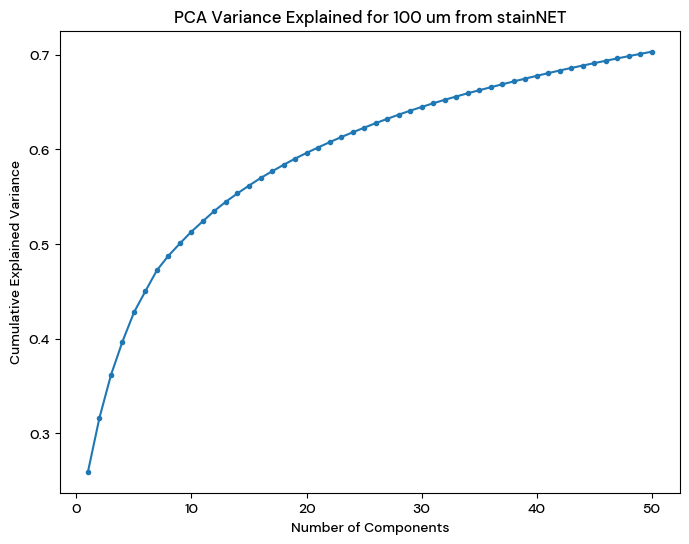

In [30]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot_nowhite = pca_cumulative_variance_plot(without_white_merged_100, normalisation_name, TILE_SIZE)
plot_nowhite.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

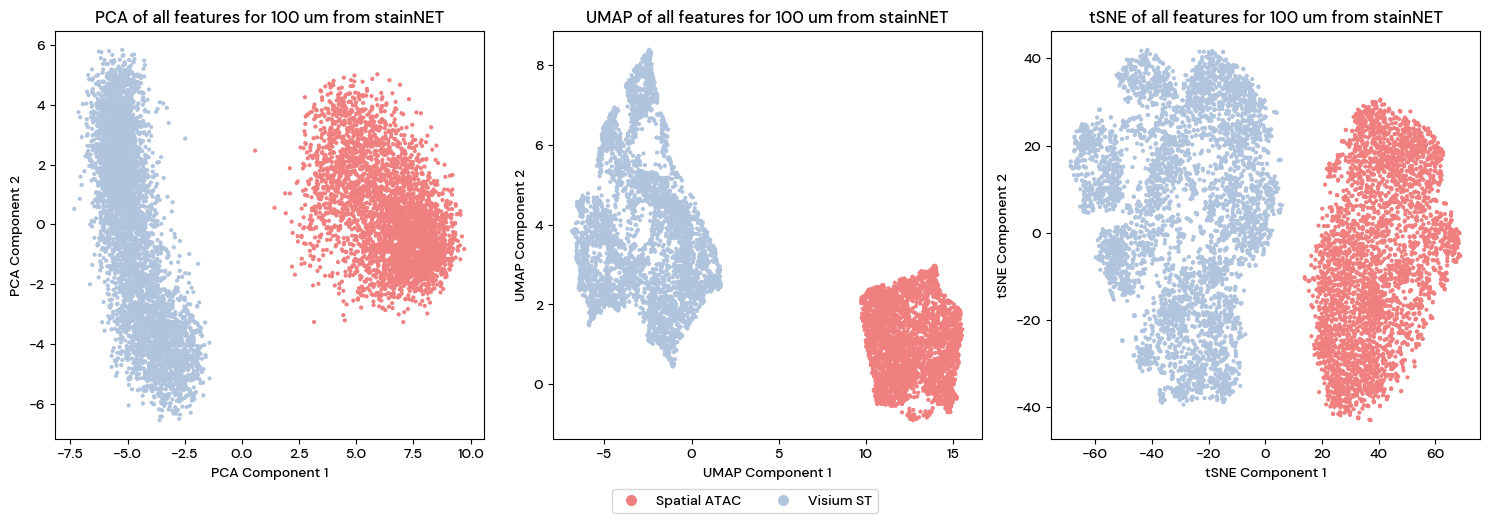

In [31]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot100_nowhite, dim_red_results_100_nowhite =  all_dim_red(without_white_merged_100, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE)
plot100_nowhite.show()

In [32]:
# plot100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
#                 format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

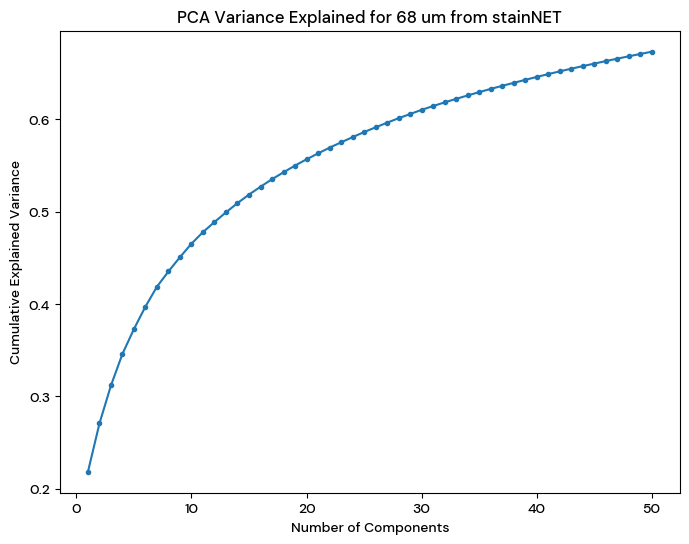

In [33]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot_nowhite = pca_cumulative_variance_plot(without_white_merged_68, normalisation_name, SPOT_SIZE)
plot_nowhite.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


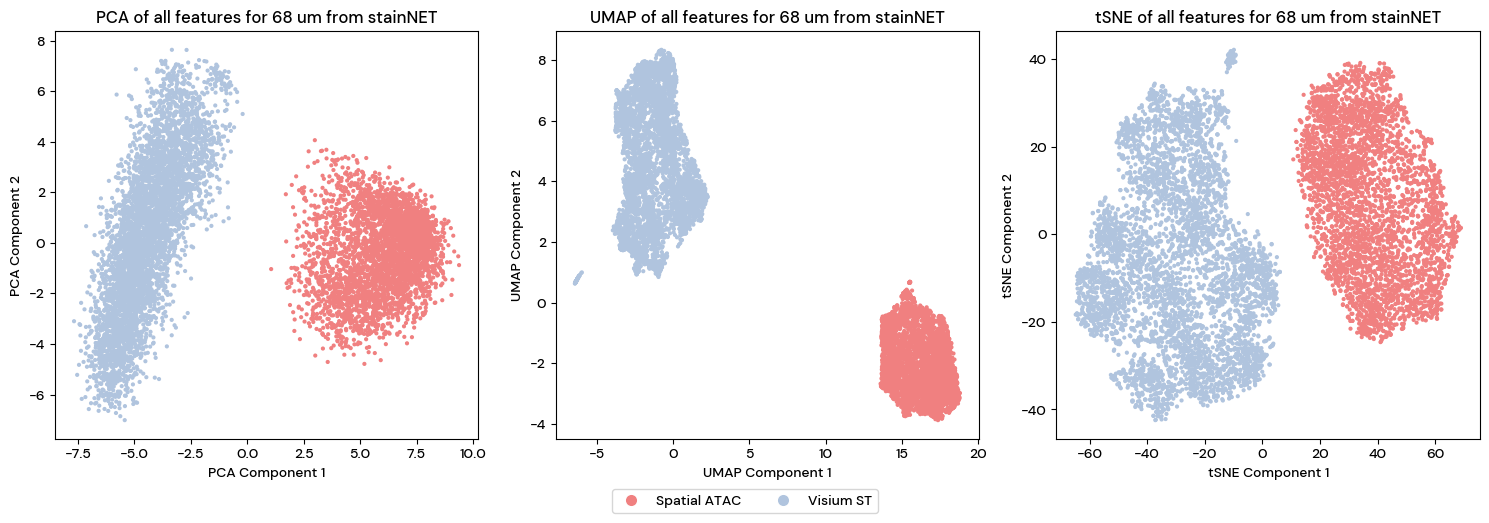

In [34]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68_nowhite, dim_red_results_68_nowhite =  all_dim_red(without_white_merged_68, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE)
plot_68_nowhite.show()

In [35]:
# plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
#                 format="PDF", bbox_inches='tight')

# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

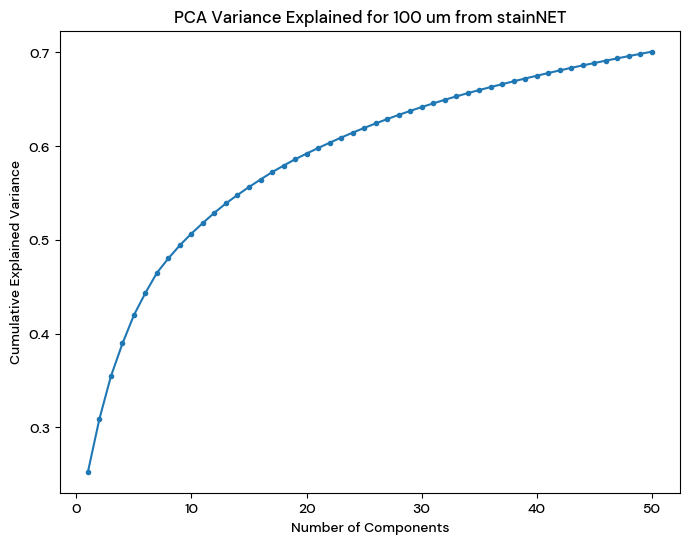

In [36]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


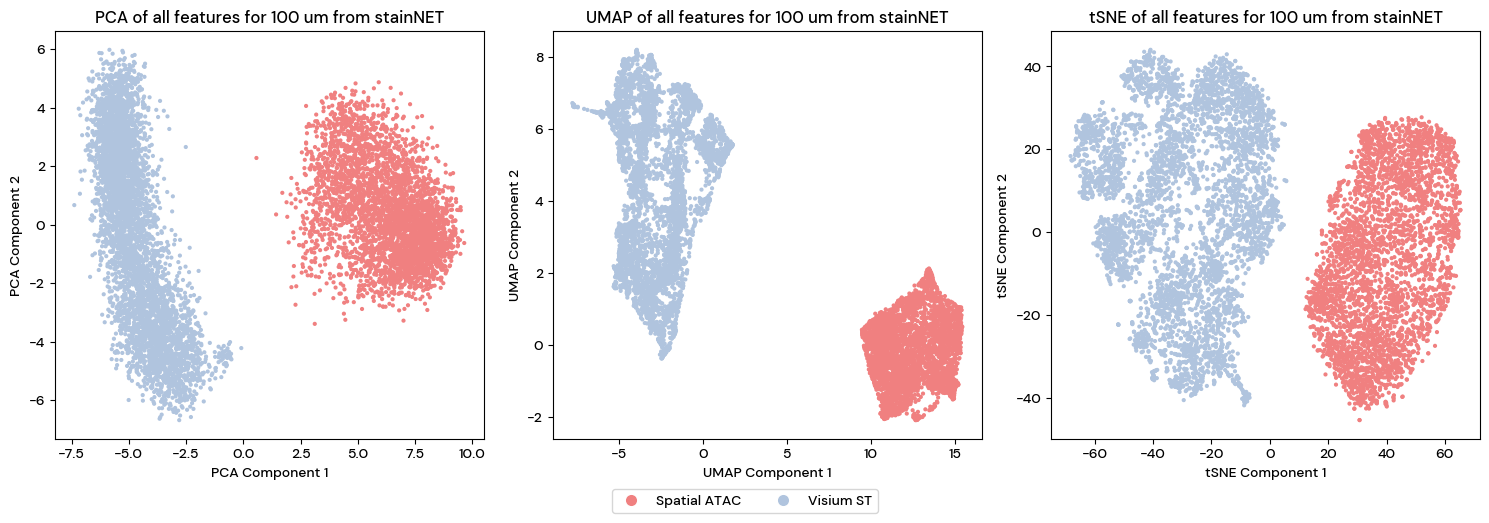

In [37]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE)
plot100.show()

In [38]:
plot100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

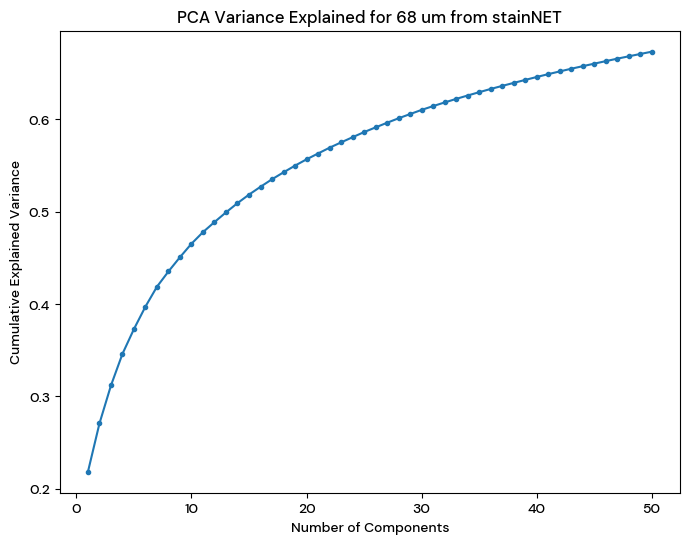

In [39]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabga

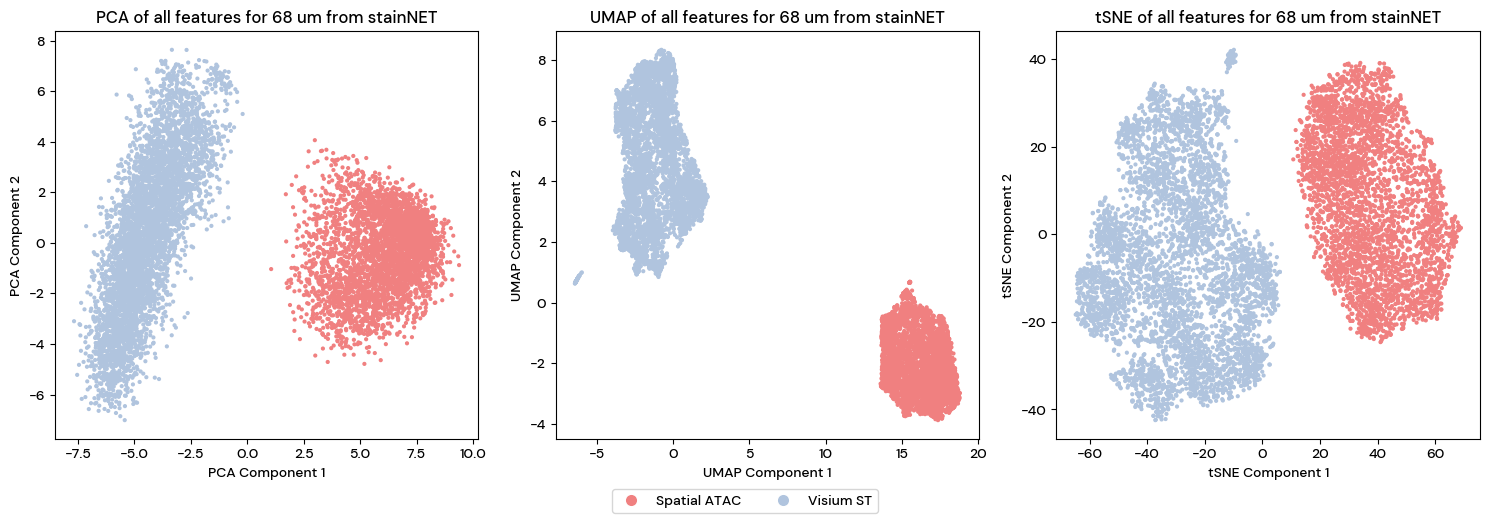

In [40]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE)
plot_68.show()

In [41]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')